In [3]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

%matplotlib inline

In [4]:
dataset_path = './winequality-red.csv'
try:
    data = pd.read_csv(dataset_path, sep=';')
except FileNotFoundError:
    print('[-] Set `dataset_path` with correct value')

V1. Exploring the green reds

a) Write a function that will plot a scatterplot matrix of your red wine data

In [5]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    """
    Plots a scatterplot matrix of wine_data.
    Samples with wine quality over good_threshold will be plotted in a different
    color than samples with wine quality below bad_threshold.
    If save_plot is True, we will save a copy of the plot as a .png file.

    @param wine_data: pd.DataFrame 
    @param good_threshold: int
    @param bad_threshold: int
    @param save_plot=False: boolean 

    @return matplotlib.pyplot.figure plot
    """
    
    num_observations, num_attributes = wine_data.shape
    fig, axes = plt.subplots(nrows=num_attributes, ncols=num_attributes, figsize=(15,15))
    fig.subplots_adjust(hspace=0, wspace=0)

    for ax in axes.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    attributes = wine_data.columns
    for i in range(num_attributes):
        axes[i, i].annotate(attributes[i], (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')

    good_wine = wine_data[wine_data.quality > good_threshold]
    bad_wine = wine_data[wine_data.quality < bad_threshold]

    for i in range(num_attributes):
        for j in range(num_attributes):
            if i != j:
                axes[i, j].scatter(good_wine.iloc[:, j], good_wine.iloc[:, i], c='C2', marker='.')
                axes[i, j].scatter(bad_wine.iloc[:, j], bad_wine.iloc[:, i], c='C3', marker='.')

    if save_plot:
        plt.savefig('./plot.png')

    return fig

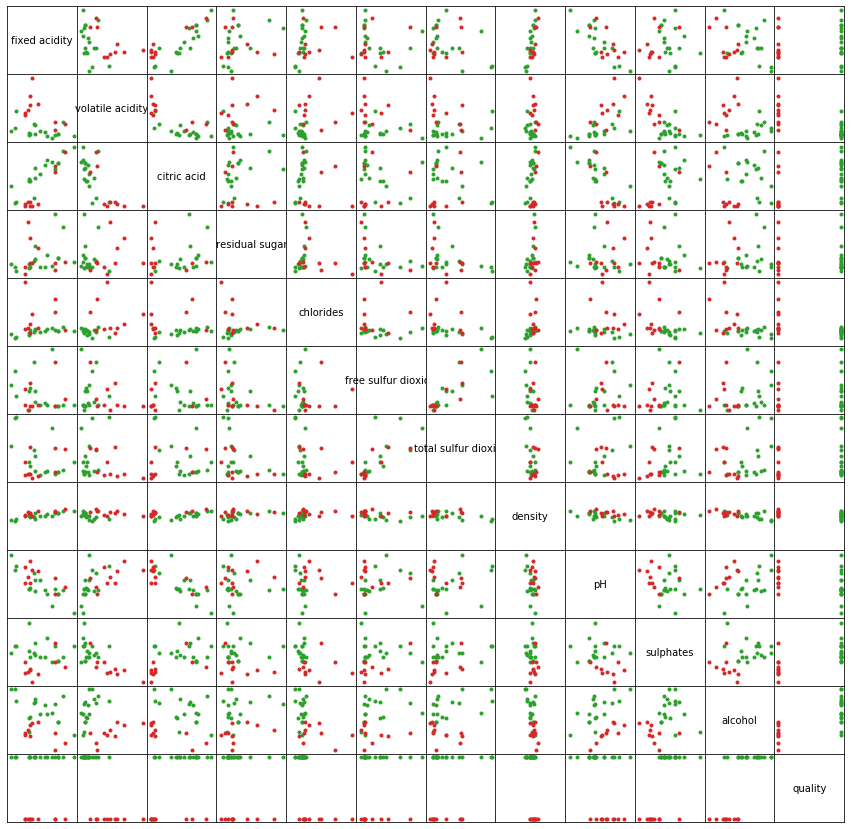

In [6]:
fig = plot_scatter_matrix(data, 7, 4, False)
plt.show(fig)

b) Which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

Alcohol and sulphates seem to be the best factors for distingushing high quality vs low quality wines.
We can see this in the scatterplot since wines with high-quality(8 or higher) also tend to have higher amounts of alcohol. The same observation happens for points with higher amounts of sulphates although the correlation is not as strong as with alcohol.
This implies that alcohol levels may have a bigger impact than sulphates levels when distinguishing the quality of a wine.  

V2. Learning to perceptron

In [7]:
# This function calculates the dot product of vectors x and w
def dot_product(x, w):
    if len(x) != len(w):
        raise ValueError("arguments must have equal length")

    result = 0
    for j in range(len(w)):
        result += x[j] * w[j]
    return result

a) Implement a perceptron using:
    • Rosenblatt perceptron learning rule (with changeable learning rate)
    • heavyside step activation function (discrete version)

b) Implement a training function that:
    • has a way to specify number of training epochs and learning rate
    • trains until number of errors is 0 if number of epochs is 0
    • returns a list of python tuples containing performance 

In [8]:
class Perceptron:
    def __init__(self):
        self.W = None
        self.learning_rate = 0
        self.performance = None

    def predict(self, xi):
        """
        This function returns the classfication for observation xi using our model's weights
        and a heavyside step activation function
        
        :param xi: vector
        :return: int: 1 or 0 
        """
        
        result = dot_product(xi, self.W[1:]) + self.W[0]
        return 1 if result > 0.0 else 0

    def train_epoch(self, X, y, epoch):
        """
        This function trains one epoch of our algorithm.
        It uses a heavyside step activation function to classify each observation and
        the Rosenblatt Perceptron learning rule to update the weights.
        After training, we add the number of classification errors and the updated weights to 
            the self.performance instance variable

        :param X: 2Dimensional array of observations: shape = (# of observations, # of attributes)
        :param y: pandas.series : the labels for our training set : shape = (# of observations)
        :param epoch: int : epoch #
        :return: int num_errors
        """
        
        num_errors = 0
        for xi, yi in zip(X, y):
            prediction = self.predict(xi)
            diff = yi - prediction
            self.W[0] += self.learning_rate * diff
            self.W[1:] += self.learning_rate * diff * xi
            num_errors += int(diff != 0.0)

        performance = (epoch, num_errors, self.W[1:], self.W[0])
        self.performance.append(performance)
        return num_errors

    def train(self, train_data, labels, num_epochs, learning_rate):
        """
        This function trains the perceptron num_epochs times, or until 0 errors if num_epochs is negative
        train_data has input values, labels are the output values, any learning rate can be specified

        :param train_data: matrix containing input variables
        :param labels: vector containing output variables as True or False values
        :param num_epochs: if num_epochs is negative, we train until there are 0 errors
        :param learning_rate:
        :return: array of tuples. Each tuple has the statistics for an epoch
                    (epoch, number of errors, [weight1, weight2], bias)
        """

        # initialize Perceptron instance variables, generate random numbers for weights and bias
        self.performance = []
        self.learning_rate = learning_rate
        self.W = [random.uniform(-1, 1) for i in range(train_data.shape[1] + 1)]

        epoch = 0
        if num_epochs < 0:
            raise ValueError("number of epochs must be non-negative")

        while True:
            errors = self.train_epoch(train_data, labels, epoch)
            if num_epochs == 0 and errors == 0:
                break
            if num_epochs != 0 and epoch >= num_epochs:
                break
            epoch += 1

        return self.performance

c) Write a function that takes the output of your perceptron training function and your red wine data and generates two plots in one figure:
    • The first plot should plot the number of errors your perceptron made
    as a function of epoch.
    • The second plot should plot the decision boundary of your perceptron
    and also show ‘good’ and ‘bad’ wine data points on the final training
    epoch. This second plot should also shade ‘good’ and ‘bad’ areas!

In [9]:
def plot_error_hist(axes, performance):
    # get arrays containing epoch and the number of misclassified wines for each epoch
    epochs = [epoch[0] for epoch in performance]
    errors = [epoch[1] for epoch in performance]

    axes[0].set_ylabel('classification errors')
    axes[0].set_xlabel('epoch')
    axes[0].set_title('Errors as a function of epoch')
    axes[0].plot(epochs, errors)


def plot_decision_boundary(axes, performance, epoch, wine_data):
    # get values for decision boundary
    w2, w1 = performance[epoch][2]
    slope = - w1 / w2
    b = performance[epoch][3]

    # get min, max from x values
    xMin = wine_data['alcohol'].min()
    xMax = wine_data['alcohol'].max()

    # Calculate y values needed to draw the line
    pHmin = slope * xMin - b / w2
    pHmax = slope * xMax - b / w2

    axes[1].set_ylim([wine_data['pH'].min(), wine_data['pH'].max()])
    axes[1].set_xlim([xMin, xMax])
    axes[1].set_title('Decision boundary on epoch: {}'.format(epoch))

    # draw line
    axes[1].plot([xMin, xMax], [pHmin, pHmax], 'b--', label='Decision boundary')
    # fill good/bad regions for given epoch
    axes[1].fill_between([xMin, xMax], [pHmin, pHmax], wine_data['pH'].min(), color='#EAFBDF')
    axes[1].fill_between([xMin, xMax], [pHmin, pHmax], wine_data['pH'].max(), color='#F8CAD0')


def plot_scatter(axes, wine_data, good_thresh, bad_thresh):
    # separate data into good wines(quality > good_thresh) and bad_wines (quality < bad_thresh)
    good_wine = wine_data[(wine_data['quality'] > good_thresh)]
    good_wine = good_wine.reset_index(drop=True)
    bad_wine = wine_data[(wine_data['quality'] < bad_thresh )]
    bad_wine = bad_wine.reset_index(drop=True)

    axes[1].set_ylabel('pH')
    axes[1].set_xlabel('alcohol')
    # draw scatter plots
    axes[1].scatter(good_wine.loc[:, 'alcohol'], good_wine.loc[:, 'pH'],  c='C2',
                    label='good wines (> {} score)'.format(good_thresh), marker='.')
    axes[1].scatter(bad_wine.loc[:, 'alcohol'], bad_wine.loc[:, 'pH'], c='C3',
                    label='bad wines (> {} score)'.format(bad_thresh), marker='.')
    axes[1].legend(bbox_to_anchor=(1, 1), loc=2)


def plot_performance(performance, wine_data, good_thresh, bad_thresh, epoch= -1, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    This function will produce two plot figures:
    1) classification Errors vs Epochs
    2) Decision boundary for two factors
    :param performance: list of tuples, each tuple contains performance information for an epoch
    :param wine_data: pandas.dataFrame
    :param good_thresh: int
    :param bad_thresh: int
    :param epoch: int that indicates the epoch that we want to display, if -1 we use the last epoch
    :param save_plot: boolean
    :return fig:
    """
    if epoch >= len(performance) or epoch < 0:
        epoch = len(performance) - 1
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    plot_error_hist(axes, performance)
    plot_decision_boundary(axes, performance, epoch, wine_data)
    plot_scatter(axes, wine_data, good_thresh, bad_thresh)

    if save_plot:
        plt.savefig('./performance_plot.png')

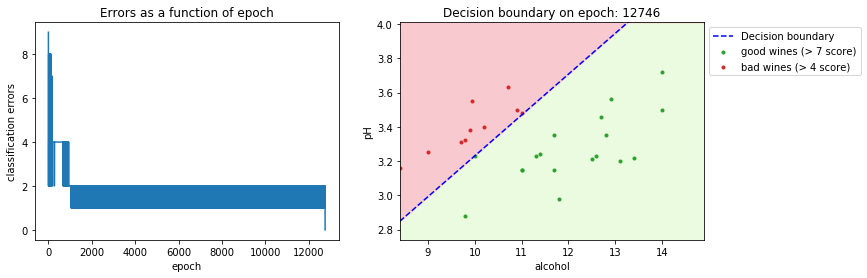

In [10]:
# add column 'label' that tells us if the wine is classified as high quality
data['label'] = data['quality'] > 5

# filter for wines with quality > 7 or quality < 4
wine_data = data[(data['quality'] > 7) | (data['quality'] < 4)][['pH', 'alcohol', 'quality', 'label']]
wine_data = wine_data.reset_index(drop=True)

# separate wine_data into train_data (inputs) and labels
labels = wine_data.loc[:, 'label']
train_data = wine_data.loc[:, ['pH', 'alcohol']]
train_data = train_data.values[:]

# train our perceptron and print performance
p = Perceptron()
p.train(train_data, labels, 0, 0.01)

# plot the performance of our perceptron
plot_performance(p.performance, data, 7, 4, -1, False)

d) Feature Scaling


In [11]:
def scale_dataframe(data):
    """
    This function normalizes the observations in the data pandas dataframe.
    It returns a dataset where the attributes have values between -1.0 and 1.0

    """
    for col in data.columns:
        if col != 'label' and col != 'quality':
            values = data[col].values[:]
            values = (values - values.mean()) / (values.max() - values.min())
            data[col].values[:] = values
    return data

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


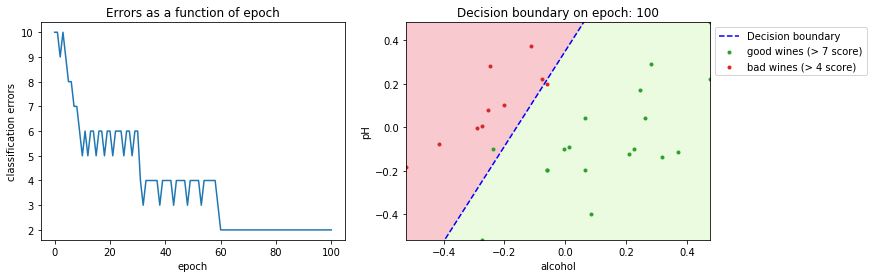

In [12]:
# make a deep copy of data and normalize columns
norm_wine_data = deepcopy(wine_data)
norm_wine_data = scale_dataframe(norm_wine_data)
norm_wine_data = norm_wine_data.reset_index(drop=True)

# create training data using normalized dataframe
norm_train_data = norm_wine_data.loc[:, ['pH', 'alcohol']]
norm_train_data = norm_train_data.as_matrix()

# train and plot performance after normalizing input data
p.train(norm_train_data, labels, 100, 0.01)
plot_performance(p.performance, norm_wine_data, 7, 4, -1, False)

V.3 My fair ADALINE

a) Marvin notices and chides you for torturing your perceptron. Why?

If we try to use our perceptron to distinguish between wines that have a score of 4 and lower, and wines with a score of 7 and higher we end up running an infinite loop.

This tells us that there is no possible set of weights that can correctly classify all the wines in the dataset. In other words, our dataset is not linearly seperable.

b) Implement an ADALINE that:
    • Has randomly initialized weights and bias
    • Uses a linear activation function and some kind of quantizer
    • Uses the Widrow-Hoff learning rule

c) Implement a function to train your ADALINE that:
    • Takes in your red wine data as a parameter
    • Has a way to specify number of training epochs
    • Train until it converges on a good set of weights, if epochs is 0
    • Has a way to specify learning rate
    • Has an option to perform either online learning or batch learning

In [13]:
def matrix_multiply(X, Y):
    """
    This function returns the result of the matrix multiplication between X and Y
    X is a 2 dimensional array, Y is a vector
    The second dimension of X must be the same size as the first dimension of Y
    :param X: 2Dimensional arraay
    :param Y: vector
    :return: vector
    """
    if len(X[0]) != len(Y):
        raise ValueError("second dimension of X does not equal first dimension of Y")

    result = [0 for i in range(len(X))]
    for i in range(len(X)):
        for j in range(len(Y)):
            result[i] += X[i][j] * Y[j]

    return result


def transpose(X):
    """
    This function returnss the transpose of the given 2-dimensional array
    :param X: 2Dimensional matrix
    :return: transpose of X
    """
    w, h = X.shape
    result = [[0 for i in range(w)] for j in range(h)]
    for i in range(h):
        for j in range(w):
            result[i][j] = X[j][i]

    return result

In [14]:
class Adaline:
    def __init__(self):
        self.W = None
        self.learning_rate = 0
        self.cost = []
        self.performance = []

    def validate_weights(self, X, y):
        """
        This function will validate our model on a validation set gathered using the k_fold sampling method.
        It will return the percentage of correctly labeled observations from the validation set after training our model
        on a training set.
    
        :param X: 2Dimensional array representing our validation set shape: (# of observations, # of features)
        :param y: pandas.series object with the correct labels for our validation set
        :return: float: accuracy of our model
        """
    
        outputs = self.predict(X)
        num_errors = 0

        for yi, output in zip(y, outputs):
            if yi != output:
                num_errors += 1
                
        return 1.0 - float(num_errors) / float(len(outputs))    
    
    
    def get_performance(self, X, y, epoch):
        """
        Calculate performance statistics for given epoch and add results to self.performance list
        """
        results = self.predict(X)
        num_errors = 0

        for yi, output in zip(y, results):
            if yi != output:
                num_errors += 1

        performance = (epoch, num_errors, self.W[1:], self.W[0])
        self.performance.append(performance)

    def predict(self, X):
        """
        This functions returns a list of predictions using the input matrix X.
        We label a wine as good quality if the output using our linear activation function is greater than 0.5

        :param X: matrix
        :return: list of booleans
        """
        results = []
        for xi in zip(X):
            x = [xi[0][i] for i in range(len(xi[0]))]
            output = self.output(x)
            results.append(output > 0.5)
        return results

    def converged(self):
        """
        This function checks if our model's weights have converged to a good set of weights.
        Weights are converged if the difference between costs of the last two epochs is less than 0.000001

        :return: boolean
        """
        if len(self.cost) > 1:
            diff = self.cost[-1] - self.cost[-2]
            diff = diff if diff > 0.0 else -diff
            if diff < 0.000001:
                return True
        return False

    def output(self, xi):
        """
        Calculate the output of the given input vector xi. xi is a vector representing one observation.
        We are using a linear activation function.

        :param xi: series
        :return: float
        """
        
        output = dot_product(xi, self.W[1:]) + self.W[0]
        return output

    def train_epoch(self, X, y, batch_learning, epoch):
        """
        This function will run one epoch of our training using the inputs X and the labels y.
        Batch_leaerning is a boolean that indicates if we will do batch learning or online learning.

        :param X: matrix
        :param y: series
        :param batch_learning: boolean
        :param epoch: int
        :return : void
        """
        errors = []

        # predict output for each vector in our input matrix. Calculate error and add error to errors list
        # update weights if we are doing online learning
        for xi, yi in zip(X, y):
            error = yi - self.output(xi)
            errors.append(error)
            if not batch_learning:
                self.W[0] += self.learning_rate * error
                self.W[1:] += self.learning_rate * error * xi

        # update weights if we are dong batch learning
        if batch_learning:
            self.W[0] += sum(errors) * self.learning_rate
            updates = [x * self.learning_rate for x in matrix_multiply(transpose(X), errors)]
            self.W[1:] = [w + u for w, u in zip(self.W[1:], updates)]

        # calculate total cost for this epoch and add to self.cost list
        cost = [err**2 for err in errors]
        self.cost.append(sum(cost) / 2.0)

        # get performance statistics for this epoch and add it to performance list
        self.get_performance(X, y, epoch)

    def train(self, X, y, num_epochs, learning_rate, batch_learning=True):
        """
        This function will initialize all the variables for out Adaline model.
        Then it will train the weights using the inputs X and the labels y.
        If number of epochs is 0 then we will train until our weights converge.

        :param X: Matrix representing then inputs for our model
        :param y: series representing the labels that will be used to calculate the errors on our prediction
        :param num_epochs: int
        :param learning_rate: float
        :param batch_learning: boolean, if False we will use online learning
        :return: void
        """

        # initialize Adaline instance variables, generate random numbers for weights and bias
        self.learning_rate = learning_rate
        self.W = [random.uniform(-1, 1) for i in range(X.shape[1] + 1)]
        self.cost = []
        self.performance = []

        epoch = 0
        if num_epochs < 0:
            raise ValueError("number of epochs must be non-negative")

        # train model
        while True:
            self.train_epoch(X, y, batch_learning, epoch)
            epoch += 1
            if num_epochs == 0 and self.converged():
                break
            if num_epochs != 0 and epoch >= num_epochs:
                break


d) Find a good learning rate for your ADALINE and plot number of classification errors vs. epoch and the decision boundary of your ADALINE

In [15]:
def plot_a_decision_boundary(axes, performance, epoch, wine_data):
    # get values for decision boundary
    w2, w1 = performance[epoch][2]
    slope = - w1 / w2
    b = performance[epoch][3] - 0.5

    # get min, max from x values
    xMin = wine_data['alcohol'].min()
    xMax = wine_data['alcohol'].max()

    # Calculate y values needed to draw the line
    pHmin = slope * xMin - b / w2
    pHmax = slope * xMax - b / w2

    axes[1].set_ylim([wine_data['pH'].min(), wine_data['pH'].max()])
    axes[1].set_xlim([xMin, xMax])
    axes[1].set_title('Decision boundary on epoch: {}'.format(epoch))

    # draw line
    axes[1].plot([xMin, xMax], [pHmin, pHmax], 'b--', label='Decision boundary')
    # fill good/bad regions for given epoch
    axes[1].fill_between([xMin, xMax], [pHmin, pHmax], wine_data['pH'].min(), color='#EAFBDF')
    axes[1].fill_between([xMin, xMax], [pHmin, pHmax], wine_data['pH'].max(), color='#F8CAD0')


def plot_adaline(performance, wine_data, good_thresh, bad_thresh, epoch= -1, save_plot=False):
    """
    Plot the performance of our adaline.
    This function will produce two plot figures:
    1) classification Errors vs Epochs
    2) Decision boundary for wine_data

    :param performance: list of tuples, each tuple contains performance information for an epoch
    :param wine_data: pandas.dataFrame
    :param good_thresh: int
    :param bad_thresh: int
    :param epoch: int that indicates the epoch that we want to display, if -1 we use the last epoch
    :param save_plot: boolean
    :return fig:
    """
    if epoch >= len(performance) or epoch < 0:
        epoch = len(performance) - 1
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    plot_error_hist(axes, performance)
    plot_a_decision_boundary(axes, performance, epoch, wine_data)
    plot_scatter(axes, wine_data, good_thresh, bad_thresh)

    if save_plot:
        plt.savefig('./performance_plot.png')
    
    return fig

In [16]:
wine_data = data[(data['quality'] >= 7) | (data['quality'] <= 4)][['pH', 'alcohol', 'quality', 'label']]
wine_data = wine_data.reset_index(drop=True)

# separate wine_data into train_data (inputs) and labels
labels = wine_data.loc[:, 'label']

# make a deep copy of data and normalize columns
norm_wine_data = deepcopy(wine_data)
norm_wine_data = scale_dataframe(norm_wine_data)
norm_wine_data = norm_wine_data.reset_index(drop=True)

# create normalized training data using normalized dataframe
X = norm_wine_data.loc[:, ['pH', 'alcohol']]
X = X.as_matrix()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


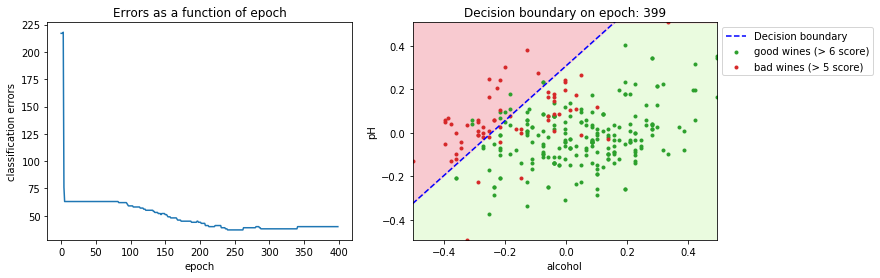

In [17]:
# good learning rate

a = Adaline()
a.train(X, labels, 400, 0.001, True)
fig = plot_adaline(a.performance, norm_wine_data, 6, 5, -1, False)

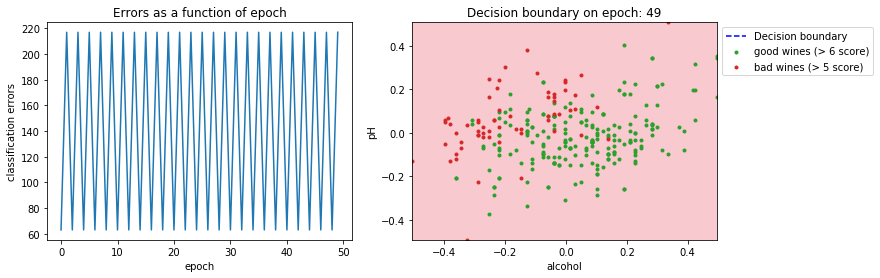

In [18]:
# big learning rate: weights change too drastically, which results in
# all of our observations to have the same classification

a = Adaline()
a.train(X, labels, 50, 0.1, True)
fig = plot_adaline(a.performance, norm_wine_data, 6, 5, -1, False)

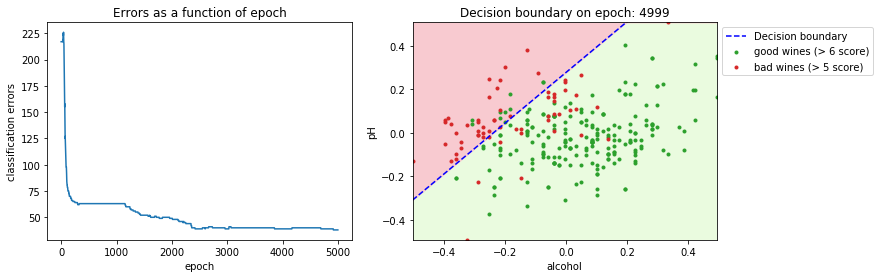

In [19]:
# small learning rate: our adaline's weights converge correctly however,
# it does so very slowly

a = Adaline()
a.train(X, labels, 5000, 0.0001, True)
fig = plot_adaline(a.performance, norm_wine_data, 6, 5, -1, False)

V.4 Advanced wine sampling and resampling

a) Write a function that uses the holdout method to partition the red wine data into a training and a validation set. The function should take a parameter to adjust the proportion of training to validation data. It should return a tuple containing:

(training_pandas_dataframe, validation_pandas_dataframe)

In [20]:
def holdout_method(wine_data, ratio=0.7):
    """
    This function uses the holdout method to partition our wine_data into two sets.
    The first set is the training data, and the second set is our validation data.
    The parameter ratio can be used to specify the proportion of training to validation data

    :param wine_data:
    :param ratio:
    :return: tuple: shape: (training data, validation data)
    """

    train = wine_data.sample(frac=ratio)
    validation = wine_data.drop(train.index)
    return (train, validation)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


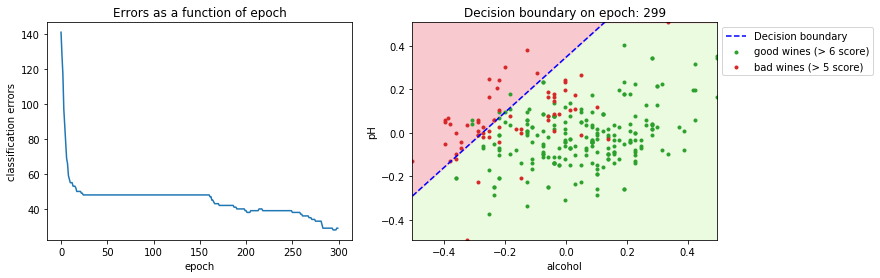

In [21]:
train_set, validation_set = holdout_method(norm_wine_data, ratio=0.7)
X_train = train_set.loc[:, ['pH', 'alcohol']]
Y_train = train_set['label']
X_train = X_train.as_matrix()

X_val = validation_set.loc[:, ['pH', 'alcohol']]
Y_val = validation_set['label']
a.train(X_train, Y_train, 300, 0.001, True)
fig = plot_adaline(a.performance, norm_wine_data, 6, 5, -1, False)

b) Write a function that generates a k-fold cross-validation dataset from the red wine data. The function should allow k to be arbitrarily adjusted and also have an optional setting to shuffle data before creating k-folds. The function should return a list of ‘k’ tuples with each tuple containing:
(training_pandas_dataframe, cross_validation_pandas_dataframe)

In [22]:
def k_fold_dataset(wine_data, k, shuffle=False):
    """
    This function generates a k-fold cross-validation dataset from the wine_data pandas dataframe.

    :param wine_data: pandas dataframe: data that we want to separate into a cross-validation dataset
    :param k: int: indicates the number of folds we watnt o separate our data into
    :param shuffle: boolean: True if we want to randomize our dataset before separating it into k folds
    :return: list of tuples: tuple shape: (training_pandas_dataframe, validation_pandas_dataframe)
    """
    if shuffle:
        wine_data = wine_data.sample(frac=1)

    datasets = []
    fold_size = int(wine_data.shape[0] / k)

    for i in range(k):
        validation_set = wine_data.iloc[i * fold_size: (i + 1) * fold_size, :]
        datasets.append((wine_data.drop(validation_set.index), validation_set))

    return datasets

c) What effects does changing learning rate and number of training epochs have on the
ADALINE when evaluated via k-fold cross-validation? To address this question,
you should write (or modify) a function that will train and assess the ADALINE
on each training and cross-validation fold produced by your k-fold function.

In [23]:
def validate_model(adaline, wine_data, k, num_epochs=300, learning_rate=0.001):
    """
    This function will first generate a k-fold cross-validation dataset of wine_data.
    Then we will train our dataset on each fold's training set and test our model on the validation set.
    We will save the accuracy for each fold.
    Finally we return the mean of the accuracies.

    :param adaline: Adaline model
    :param wine_data: Pandas dataframe that we want to model
    :param k: int: specifies how many folds we want to use for our k-folds cross validation
    :param num_epochs: int: the number of epochs that we want to train our data for
    :param learning_rate: specifies the learning rate for our Adaline model
    :return:
    """

    k_fold_sets = k_fold_dataset(wine_data, k, True)
    accuracy = []

    for fold in k_fold_sets:
        X = fold[0].loc[:, ['pH', 'alcohol']]
        X = X.as_matrix()
        labels = fold[0].loc[:, 'label']
        adaline.train(X, labels, num_epochs, learning_rate, False)
        accuracy.append(adaline.validate_weights(fold[1].loc[:, ['pH', 'alcohol']].as_matrix(), fold[1].loc[:, 'label']))
        print('model accuracy: {}'.format(accuracy[-1]))

    print('Mean model accuracy: {} - {} folds, lr: {}, num_epochs: {}'.format(sum(accuracy) / len(accuracy), k, learning_rate, num_epochs))
    return sum(accuracy) / len(accuracy)

In [24]:
model_accuracy = validate_model(a, norm_wine_data, 10, num_epochs=300, learning_rate=0.01)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


model accuracy: 0.8928571428571429
model accuracy: 0.8571428571428572
model accuracy: 0.8214285714285714
model accuracy: 0.8571428571428572
model accuracy: 0.8928571428571429
model accuracy: 0.9285714285714286
model accuracy: 0.8571428571428572
model accuracy: 0.9285714285714286
model accuracy: 0.7857142857142857
model accuracy: 0.7857142857142857
Mean model accuracy: 0.8607142857142858 - 10 folds, lr: 0.01, num_epochs: 300


V.5 Adventures in the Nth dimension

a) Try training your perceptron/ADALINE with different numbers and types of chemical
factors. Under what circumstances can your perceptron/ADALINE successfully
train?

I will try training my Adaline using different attributes to see if I get better results.

In [25]:
# only use wines with quality > 7 or quality < 4
wine_data = deepcopy(data)
wine_data = wine_data[(wine_data['quality'] >= 7) | (wine_data['quality'] <= 4)]

# normalize wine_data
wine_data = scale_dataframe(wine_data)
wine_data = wine_data.reset_index(drop=True)

# use holdout method to separate wine_data into training and validation sets
train, validation = holdout_method(wine_data, 0.7)
train_y = train.loc[:, 'label']
validation_y = validation.loc[:, 'label']

p = Perceptron()
a = Adaline()

In [26]:
# train with all attributes except alcohol, volatile acidity, and pH
X_train = train.loc[:, ['fixed acidity', 'citric acid', 'residual sugar',
                          'free sulfur dioxide', 'total sulfur dioxide',
                          'density', 'sulphates', 'chlorides']]
X_validation = validation.loc[:, ['fixed acidity', 'citric acid', 'residual sugar',
                          'free sulfur dioxide', 'total sulfur dioxide',
                          'density', 'sulphates', 'chlorides']]

X_train = X_train.values[:]
X_validation = X_validation.values[:]
a.train(X_train, train_y, 1000, 0.001, True)
for i in range(len(a.performance)):
    if i % 50 == 0:
        print('epoch: {}, num_errors: {}'.format(a.performance[i][0], a.performance[i][1]))

print(a.performance[-1][2])
print('Accuracy of our model on validation set: {}'.format(a.validate_weights(X_validation, validation_y)))

epoch: 0, num_errors: 154
epoch: 50, num_errors: 50
epoch: 100, num_errors: 47
epoch: 150, num_errors: 44
epoch: 200, num_errors: 37
epoch: 250, num_errors: 35
epoch: 300, num_errors: 36
epoch: 350, num_errors: 36
epoch: 400, num_errors: 35
epoch: 450, num_errors: 36
epoch: 500, num_errors: 35
epoch: 550, num_errors: 34
epoch: 600, num_errors: 31
epoch: 650, num_errors: 29
epoch: 700, num_errors: 29
epoch: 750, num_errors: 28
epoch: 800, num_errors: 28
epoch: 850, num_errors: 28
epoch: 900, num_errors: 27
epoch: 950, num_errors: 27
[0.032346479088116595, 0.8154507361639147, 0.36606824501835006, -0.10801294209406559, -0.08340791732823388, -0.7926870704728378, 1.0544848116551881, -0.9664358682009941]
Accuracy of our model on validation set: 0.8333333333333334


In [27]:
# train with 'residual sugar' and 'free sulfur dioxide'
X_train = train.loc[:, ['residual sugar', 'free sulfur dioxide']]
X_validation = validation.loc[:, ['residual sugar', 'free sulfur dioxide']]

X_train = X_train.values[:]
X_validation = X_validation.values[:]
a.train(X_train, train_y, 1000, 0.001, True)
for i in range(len(a.performance)):
    if i % 50 == 0:
        print('epoch: {}, num_errors: {}'.format(a.performance[i][0], a.performance[i][1]))

print(a.performance[-1][2])
print('Accuracy of our model on validation set: {}'.format(a.validate_weights(X_validation, validation_y)))

epoch: 0, num_errors: 154
epoch: 50, num_errors: 42
epoch: 100, num_errors: 42
epoch: 150, num_errors: 42
epoch: 200, num_errors: 42
epoch: 250, num_errors: 42
epoch: 300, num_errors: 42
epoch: 350, num_errors: 42
epoch: 400, num_errors: 42
epoch: 450, num_errors: 42
epoch: 500, num_errors: 42
epoch: 550, num_errors: 42
epoch: 600, num_errors: 42
epoch: 650, num_errors: 42
epoch: 700, num_errors: 42
epoch: 750, num_errors: 42
epoch: 800, num_errors: 42
epoch: 850, num_errors: 42
epoch: 900, num_errors: 42
epoch: 950, num_errors: 42
[0.31103764036296055, 0.06799676231497354]
Accuracy of our model on validation set: 0.75


In [28]:
# train with alcohol, volatile acidity, and pH
X_train = train.loc[:, ['alcohol', 'volatile acidity', 'pH']]
X_validation = validation.loc[:, ['alcohol', 'volatile acidity', 'pH']]

X_train = X_train.values[:]
X_validation = X_validation.values[:]
a.train(X_train, train_y, 1000, 0.001, True)
for i in range(len(a.performance)):
    if i % 50 == 0:
        print('epoch: {}, num_errors: {}'.format(a.performance[i][0], a.performance[i][1]))

print(a.performance[-1][2])    
print('Accuracy of our model on validation set: {}'.format(a.validate_weights(X_validation, validation_y)))

epoch: 0, num_errors: 110
epoch: 50, num_errors: 31
epoch: 100, num_errors: 27
epoch: 150, num_errors: 22
epoch: 200, num_errors: 19
epoch: 250, num_errors: 21
epoch: 300, num_errors: 21
epoch: 350, num_errors: 21
epoch: 400, num_errors: 21
epoch: 450, num_errors: 21
epoch: 500, num_errors: 21
epoch: 550, num_errors: 21
epoch: 600, num_errors: 21
epoch: 650, num_errors: 21
epoch: 700, num_errors: 21
epoch: 750, num_errors: 21
epoch: 800, num_errors: 21
epoch: 850, num_errors: 21
epoch: 900, num_errors: 21
epoch: 950, num_errors: 21
[0.866998028407255, -1.1796878792900232, -0.5002511997451171]
Accuracy of our model on validation set: 0.8928571428571429


Our adaline got different results depending on which atributes we used. 
Alcohol, volatile acidity, and pH seem to be the most influental so when I trained my data using only these attributes I got the best results.
Similarly, 'residual sugar' and 'free sulfur dioxide' seem to be the least influential and training with these attributes resulted in lower accuracy during classification.

My adaline seems to train succesfully when I train it using attributes that are more influential (i.e have bigger weights after training).

Training with all the attributes gets me slightly better results than if I train with only 3 attributes. However, we need to be careful not to overfit our data.

b) You know what the decision boundary for 2 wine chemical factors looks like, but what
does the decision boundary for 3 factors look like? What about if you use 7 factors?
How about if you use all 11 wine chemical factors?

When we had two chemical factors, our decision boundary was a line.
If we use three chemical factors, our decision boundary will be a plane
For a dimension n that's higher than 3, the decision boundary will be a hyperplane with dimension n-1.

V.6 Marvin’s rebuttal

In [29]:
dataset_path = './pan_galactic_gargle_blaster.csv'
try:
    pan_galactic = pd.read_csv(dataset_path, sep=';')
except FileNotFoundError:
    print('[-] Set `dataset_path` with correct value')

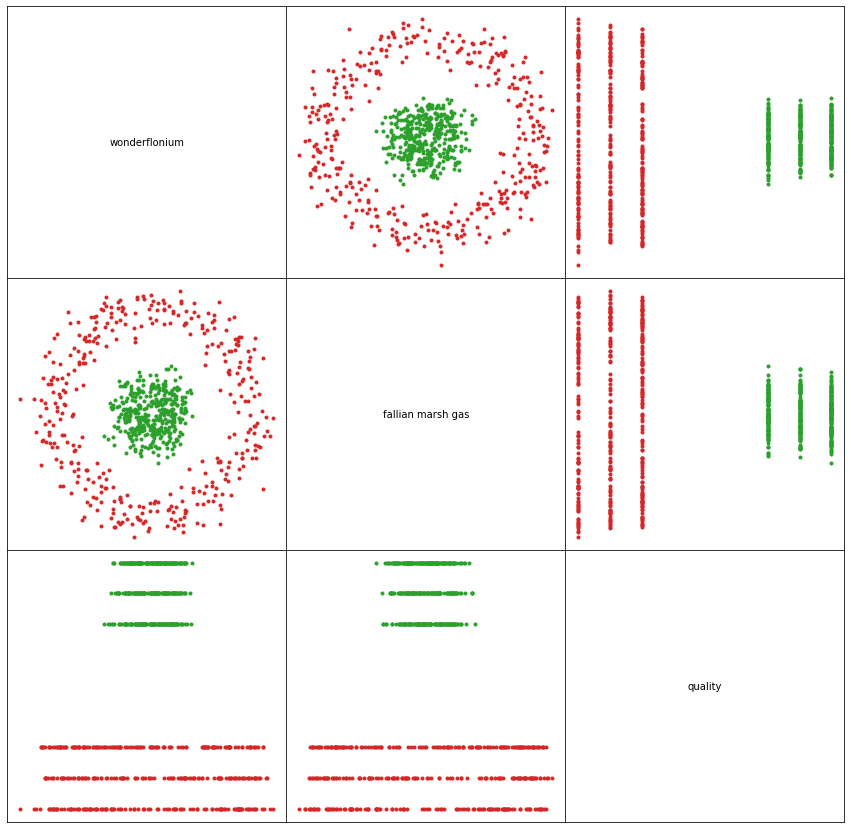

In [30]:
fig = plot_scatter_matrix(pan_galactic, 6, 4, False)

This scatter plot shows us that our dataset is not linearly separable.
If we try to train our Adaline or Perceptron on it, we will never converge to a set of weights that correctly classify all points.

However, it is evident that points that are close to the middle are labeled as high quality and those points that are further away from the origin are low quality.

If we add a column that has the distance from each point to the middle, we can use that attribute to correctly classify our data.

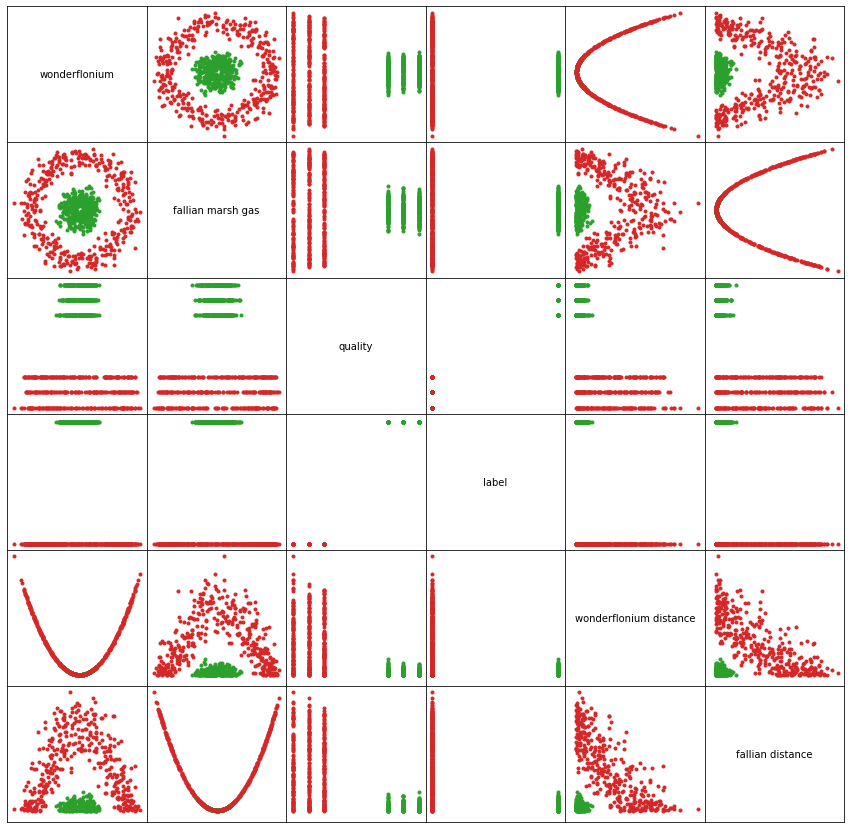

In [31]:
pan_galactic['label'] = pan_galactic['quality'] > 5
norm_pan = scale_dataframe(pan_galactic)
norm_pan['wonderflonium distance'] = norm_pan['wonderflonium']**2
norm_pan['fallian distance'] = norm_pan['fallian marsh gas']**2

fig = plot_scatter_matrix(norm_pan, 6, 4, False)

Now we have a dataset that is linearly separable so we can succesfully train our perceptron.

In [32]:
norm_pan = norm_pan[(norm_pan['quality'] > 6) | (norm_pan['quality'] < 4)]
y = norm_pan.loc[:, 'label']
X = norm_pan.loc[:, ['wonderflonium distance', 'fallian distance']]

p.train(X.values[:], y, 0, 0.001)
print(p.performance[-1])

(20, 0, [-0.0026790046568392328, -0.0027757084504522757], 0.0002029493160625789)


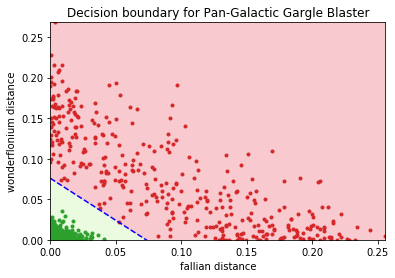

In [33]:
# get values for decision boundary
w2, w1 = p.performance[-1][2]
slope = - w1 / w2
b = p.performance[-1][3]

# get min, max from x values
xMin = X['fallian distance'].min()
xMax = X['fallian distance'].max()

# Calculate y values needed to draw the line
ymin = slope * xMin - b / w2
ymax = slope * xMax - b / w2

plt.ylim([X['wonderflonium distance'].min(), X['wonderflonium distance'].max()])
plt.xlim([xMin, xMax])
plt.title('Decision boundary for Pan-Galactic Gargle Blaster')
plt.xlabel('fallian distance')
plt.ylabel('wonderflonium distance')

# draw line
plt.plot([xMin, xMax], [ymin, ymax], 'b--', label='Decision boundary')

# fill good/bad regions
plt.fill_between([xMin, xMax], [ymin, ymax], X['wonderflonium distance'].min(), color='#EAFBDF')
plt.fill_between([xMin, xMax], [ymin, ymax], X['wonderflonium distance'].max(), color='#F8CAD0')

# separate norm_pan data into good quality and bad quality
X_good = norm_pan[(norm_pan['quality'] > 6)]
X_bad = norm_pan[(norm_pan['quality'] < 4)]


plt.scatter(X_good.loc[:, 'fallian distance'], X_good.loc[:, 'wonderflonium distance'],
           c='C2', marker='.')
plt.scatter(X_bad.loc[:, 'fallian distance'], X_bad.loc[:, 'wonderflonium distance'],
           c='C3', marker='.')

VI.3 Dimension traveler

In [34]:
from mpl_toolkits.mplot3d import Axes3D

In [213]:
# only use wines with quality > 7 or quality < 4
wine_data = deepcopy(data)
wine_data = wine_data[(wine_data['quality'] > 7) | (wine_data['quality'] < 4)]

# normalize wine_data
wine_data = scale_dataframe(wine_data)
wine_data = wine_data.reset_index(drop=True)

X = wine_data.loc[:, ['alcohol', 'volatile acidity', 'pH']]
X = X.values[:]
y = wine_data.loc[:, 'label']
p.train(X, y, 1000, 0.001)

[(0,
  18,
  [0.23252186264559715, 0.7127611250377817, -0.0971328456106993],
  -0.7081944669291607),
 (1,
  18,
  [0.23497785754355638, 0.7105151834793402, -0.09813369595083535],
  -0.6901944669291606),
 (2,
  18,
  [0.2374338524415156, 0.7082692419208987, -0.09913454629097139],
  -0.6721944669291606),
 (3,
  18,
  [0.23988984733947483, 0.7060233003624572, -0.10013539663110743],
  -0.6541944669291606),
 (4,
  18,
  [0.24234584223743405, 0.7037773588040157, -0.10113624697124347],
  -0.6361944669291606),
 (5,
  18,
  [0.24480183713539327, 0.7015314172455742, -0.10213709731137952],
  -0.6181944669291606),
 (6,
  18,
  [0.2472578320333525, 0.6992854756871327, -0.10313794765151556],
  -0.6001944669291606),
 (7,
  18,
  [0.24971382693131172, 0.6970395341286912, -0.1041387979916516],
  -0.5821944669291605),
 (8,
  18,
  [0.2521698218292709, 0.6947935925702498, -0.10513964833178764],
  -0.5641944669291605),
 (9,
  18,
  [0.25462581672723006, 0.6925476510118083, -0.10614049867192368],
  -0.5461

In [214]:
import numpy as np

def plot_scatter_3D(ax, X, good_thresh, bad_thresh):
    """
    This function plots our wine data into a 3D scatter plot
    Good quality points are drawn in green and bad quality points in red
    
    :param ax: matplotlib 3D Ax
    :param X: pandas dataframe
    :param good_thresh: int : observations with quality above good_thresh are labeled good
    :param bad_thresh: int : observations with quality below bad_thresh are labeled good
    :return:
    """
    
    ax.set_xlabel('alcohol')
    ax.set_ylabel('volatile acidity')
    ax.set_zlabel('pH')
    X = X.loc[:, ['alcohol', 'volatile acidity', 'pH', 'quality']]
    
    good_wine = X[(X['quality'] > good_thresh)]
    bad_wine = X[X['quality'] < bad_thresh]
    
    ax.scatter(good_wine.loc[:, 'alcohol'], good_wine.loc[:, 'volatile acidity'], 
               good_wine.loc[:, 'pH'],  c='C2')
    ax.scatter(bad_wine.loc[:, 'alcohol'], bad_wine.loc[:, 'volatile acidity'], 
               bad_wine.loc[:, 'pH'],  c='C3')
    
def plot_surface(ax, weights, d):
    """
    This function plots the decision boundary which is a 3 dimensional plane
    """
    
    # create x,y
    xx = []
    yy = []  
        
    xx, yy = np.meshgrid(np.linspace(-.5, .5, 10), np.linspace(-.5, .5, 10))
    
    w1, w2, w3 = weights
    print(w1)
    print(w2)
    print(w3)
    
    # calculate slopes for surface w1*x + w2*y + w3*z + d = 0
    x_slope = -w1 / w3
    y_slope = -w2 / w3
    d = -d / w3
    
    # calculate z values using xx, yy values and above equation
    z_values = x_slope * xx + y_slope * yy + d
    
    ax.set_zlim3d(-1.0, .1)
    ax.plot_surface(xx, yy, z_values,
                        alpha=.5,
                        color='C3',
                        linewidth=5,
                        vmin=np.min(z_values),
                        vmax=np.max(z_values))

def plot_3D(performance, X, good_thresh, bad_thresh, epoch=-1):
    """
    Plot the 3D decision boundary of our perceptron and a scatter plot of our data.
    
    :param performance: list of tuples, each tuple contains performance information for an epoch
    :param X: pandas.dataFrame
    :param good_thresh: int
    :param bad_thresh: int
    :param epoch: int that indicates the epoch that we want to display, if -1 we use the last epoch
    :return fig:
    """
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    plot_surface(ax, performance[epoch][2], performance[epoch][3])
    plot_scatter_3D(ax, X, good_thresh, bad_thresh)
    

0.34654801060478546
0.0732078241719818
-0.38970342384199635


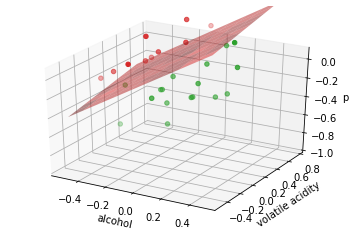

In [215]:
plot_3D(p.performance, wine_data, 7, 4, -1)